# Improvements to a Neural Network

In a previous notebook we implemented a simple feedforward neural network and used it to classify handwritten digits. In this notebook we modify the simple network, adding several improvements which improve the accuracy of the network. As before, the code in this notebook is an adaption of the code (network2.py) included with the book "[Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/)" by Michael Nielsen, specifically the [version and adapted to work with Python 3](https://github.com/MichalDanielDobrzanski/DeepLearningPython) by Michal Daniel Dobrzanski.

## Implementation of the Network

### Helpful libraries and convenience functions

First, we load some standard Python libraries.

In [6]:
import json
import random
import sys
import numpy as np

Define a convenience function for identifying which digit the network recognised.

In [7]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

A function for loading a previously-saved network.

In [8]:
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

### Activation function

We now define our activation function and another function to compute its derivative

In [9]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

### Cost functions

We will be adding support in our Network class for different choices of cost function. For this, a cost function should be defined as a class  with two functions:
* fn(a, y): compute the cost for a given a and y
* delta: compute the error, $\delta^L$ in the output layer.

We now define two specific cost functions

#### Quadratic cost

In [10]:
class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.

        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)

####  Cross-entropy cost

In [11]:
class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a-y)

### Network class

Next, we define a class "Network" that will represent our neural network. This includes several modifications to the previous class, primarily to allow for different cost functions, regularization, better weight initialization, and early stopping.

In [15]:
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).

        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        """
        #self.biases = [1 for y in self.sizes[1:,]]
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            early_stopping_n = 0):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.

        """

        # early stopping functionality:
        best_accuracy=1

        training_data = list(training_data)
        n = len(training_data)

        if evaluation_data:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)

        # early stopping functionality:
        best_accuracy=0
        no_accuracy_change=0

        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))

            print("Epoch %s training complete" % j)

            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))

            # Early stopping:
            if early_stopping_n > 0:
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    no_accuracy_change = 0
                    #print("Early-stopping: Best so far {}".format(best_accuracy))
                else:
                    no_accuracy_change += 1

                if (no_accuracy_change == early_stopping_n):
                    #print("Early-stopping: No accuracy change in last epochs: {}".format(early_stopping_n))
                    return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.

        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]

        result_accuracy = sum(int(x == y) for (x, y) in results)
        return result_accuracy

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights) # '**' - to the power of.
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

## Example

We now look at a simple example, running the new network with the quadratic cost function, no regularization and the original method for initializing the weights. First, we load the training data:

In [28]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [17]:
net = Network([784, 30, 10], cost=QuadraticCost)
net.large_weight_initializer()
net.SGD(training_data, 10, 10, 3.0, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9028 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9224 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9341 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9323 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9366 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9410 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9426 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9399 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9420 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9467 / 10000


([], [9028, 9224, 9341, 9323, 9366, 9410, 9426, 9399, 9420, 9467], [], [])

## Exercises

### Cross-entropy cost function
1. Train network with a single hidden layer with 30 neurons using the cross-entropy cost function. Note: you should use a different learning rate to produce comparable results. A good rule of thumb is to reduce the rate by a factor of 6 when using a cross-entropy cost function compared to a quadratic cost function.
2. Compare the accuracy against the quadratic cost case.
3. Repeat, but with 100 neurons.

### Overfitting and regularization
1. Train a 30 neuron network with a 1000-sample subset of the MNIST training data. Use the cross-entropy cost function and train for 400 epochs. Enabe monitoring of the evaluation accuracy and training cost and plot the results.
2. Train the network again, but this time including regularization by setting `lmbda=0.1`.
3. Compare the results in the two cases.


### Weight initialization
1. Train your network again, but this time use the improved `default_weight_initializer` weight initialization.
2. Compare the accuracy with previous cases.

In [29]:
net = Network([784,30,10])
net.large_weight_initializer()
net.SGD(training_data, 10, 10, 3.0/6, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9141 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9298 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9347 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9390 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9432 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9428 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9506 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9479 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9501 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9509 / 10000


([], [9141, 9298, 9347, 9390, 9432, 9428, 9506, 9479, 9501, 9509], [], [])

In [31]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

net = Network([784,50,50,10])
net.large_weight_initializer()
net.SGD(training_data, 10, 10, 3.0/6, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9003 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9287 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9349 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9427 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9475 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9455 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9483 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9535 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9530 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9512 / 10000


([], [9003, 9287, 9349, 9427, 9475, 9455, 9483, 9535, 9530, 9512], [], [])

In [43]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
net = Network([784,30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
res = net.SGD(list(training_data)[:1000], 400, 10, 0.5,
        evaluation_data=list(test_data)[:1000],
        monitor_evaluation_accuracy=True,
        monitor_evaluation_cost=True,
        monitor_training_cost=True)

Epoch 0 training complete
Cost on training data: 1.8385310200640463
Cost on evaluation data: 2.344231643749102
Accuracy on evaluation data: 518 / 1000
Epoch 1 training complete
Cost on training data: 1.2999063083423654
Cost on evaluation data: 1.8921233188112092
Accuracy on evaluation data: 629 / 1000
Epoch 2 training complete
Cost on training data: 1.06620400669647
Cost on evaluation data: 1.692469063699584
Accuracy on evaluation data: 694 / 1000
Epoch 3 training complete
Cost on training data: 0.8707104210341283
Cost on evaluation data: 1.5626104380417385
Accuracy on evaluation data: 714 / 1000
Epoch 4 training complete
Cost on training data: 0.7614479815520155
Cost on evaluation data: 1.522564444396154
Accuracy on evaluation data: 734 / 1000
Epoch 5 training complete
Cost on training data: 0.6630124325741917
Cost on evaluation data: 1.4610159064782087
Accuracy on evaluation data: 745 / 1000
Epoch 6 training complete
Cost on training data: 0.5846740317119148
Cost on evaluation data: 

In [38]:
import matplotlib.pyplot as plt

In [41]:
res

([],
 [554,
  653,
  701,
  721,
  729,
  753,
  765,
  776,
  779,
  780,
  788,
  790,
  790,
  790,
  785,
  797,
  793,
  794,
  800,
  804,
  800,
  798,
  801,
  806,
  800,
  809,
  803,
  806,
  805,
  807,
  801,
  803,
  806,
  807,
  797,
  804,
  809,
  810,
  808,
  808,
  809,
  812,
  809,
  813,
  812,
  813,
  812,
  811,
  818,
  810],
 [1.8354249341878928,
  1.3452952679893335,
  1.100509366398287,
  0.9321901879301097,
  0.8152085773122145,
  0.7130134228916393,
  0.6331638609729269,
  0.5758851280465221,
  0.5017406400975308,
  0.4587560350464728,
  0.4023024245403167,
  0.36839334769789417,
  0.34434151324742607,
  0.3097792233022436,
  0.2926913934148805,
  0.2600305738667014,
  0.24209104719526398,
  0.23023828825283485,
  0.2102217425460402,
  0.2015016981585868,
  0.1861397523464055,
  0.1753167428611559,
  0.16814493516770823,
  0.16029975909359065,
  0.15188760911899304,
  0.14349439706629413,
  0.1359894599785414,
  0.12980976123173876,
  0.1245606701325835

Text(0, 0.5, 'Accuracy (Number of correct labels)')

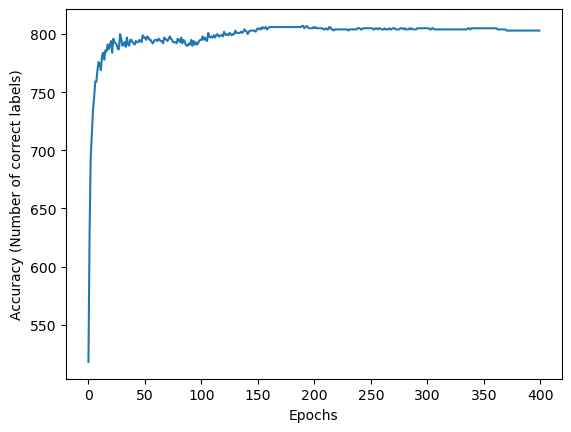

In [44]:
plt.plot([x for x in range(len(res[1]))],res[1])
plt.xlabel("Epochs")
plt.ylabel("Accuracy (Number of correct labels)")

Text(0, 0.5, 'Cost')

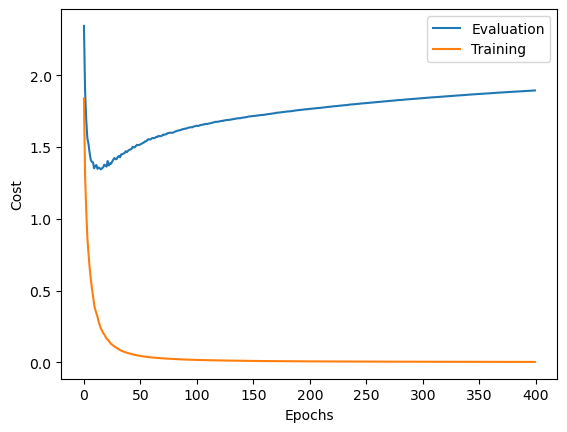

In [48]:
plt.plot([x for x in range(len(res[1]))],res[0],label="Evaluation")
plt.plot([x for x in range(len(res[1]))],res[2],label="Training")


plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Cost")

In [49]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
net = Network([784,30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
res = net.SGD(list(training_data)[:1000], 400, 10, 0.5,
        evaluation_data=list(test_data)[:1000],
        monitor_evaluation_accuracy=True,
        monitor_evaluation_cost=True,
        monitor_training_cost=True,
        lmbda=0.1)

Epoch 0 training complete
Cost on training data: 3.221466943226763
Cost on evaluation data: 3.587934783216415
Accuracy on evaluation data: 496 / 1000
Epoch 1 training complete
Cost on training data: 2.5678008460117394
Cost on evaluation data: 3.115434859694796
Accuracy on evaluation data: 611 / 1000
Epoch 2 training complete
Cost on training data: 2.3107007845742746
Cost on evaluation data: 2.9446461317953987
Accuracy on evaluation data: 666 / 1000
Epoch 3 training complete
Cost on training data: 2.130453698370656
Cost on evaluation data: 2.8375255865064926
Accuracy on evaluation data: 693 / 1000
Epoch 4 training complete
Cost on training data: 1.9791213794750595
Cost on evaluation data: 2.733451093023575
Accuracy on evaluation data: 710 / 1000
Epoch 5 training complete
Cost on training data: 1.8497343434170335
Cost on evaluation data: 2.6616706423748435
Accuracy on evaluation data: 734 / 1000
Epoch 6 training complete
Cost on training data: 1.7490070110165155
Cost on evaluation data: 

Text(0, 0.5, 'Cost')

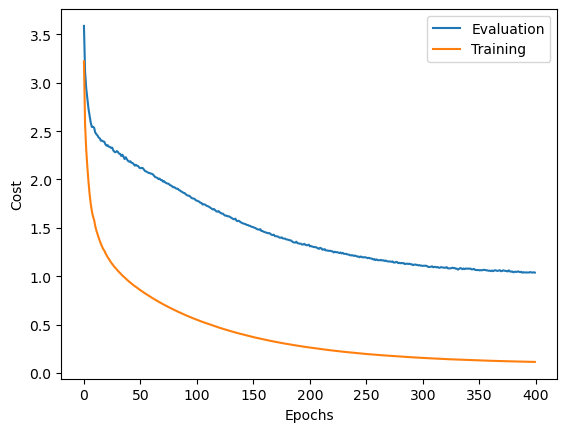

In [50]:
plt.plot([x for x in range(len(res[1]))],res[0],label="Evaluation")
plt.plot([x for x in range(len(res[1]))],res[2],label="Training")


plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Cost")

In [51]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
net = Network([784,30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
res = net.SGD(list(training_data)[:1000], 800, 10, 0.5,
        evaluation_data=list(test_data)[:1000],
        monitor_evaluation_accuracy=True,
        monitor_evaluation_cost=True,
        monitor_training_cost=True,
        lmbda=0.1)

Epoch 0 training complete
Cost on training data: 2.996083190094156
Cost on evaluation data: 3.4231050245539185
Accuracy on evaluation data: 536 / 1000
Epoch 1 training complete
Cost on training data: 2.5547314748385714
Cost on evaluation data: 3.1445527387422993
Accuracy on evaluation data: 580 / 1000
Epoch 2 training complete
Cost on training data: 2.2052585534689952
Cost on evaluation data: 2.830254631065607
Accuracy on evaluation data: 671 / 1000
Epoch 3 training complete
Cost on training data: 2.0814077871930485
Cost on evaluation data: 2.7451587711954626
Accuracy on evaluation data: 694 / 1000
Epoch 4 training complete
Cost on training data: 1.9148287756058995
Cost on evaluation data: 2.645269421184045
Accuracy on evaluation data: 712 / 1000
Epoch 5 training complete
Cost on training data: 1.7664714157241292
Cost on evaluation data: 2.524901500610765
Accuracy on evaluation data: 743 / 1000
Epoch 6 training complete
Cost on training data: 1.7028412955477148
Cost on evaluation data:

Text(0, 0.5, 'Cost')

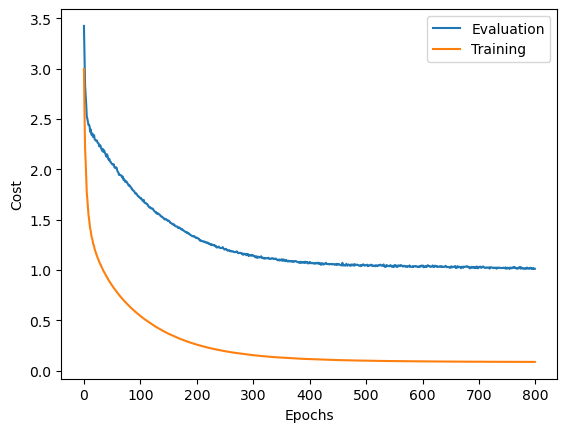

In [52]:
plt.plot([x for x in range(len(res[1]))],res[0],label="Evaluation")
plt.plot([x for x in range(len(res[1]))],res[2],label="Training")


plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Cost")

In [53]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
net = Network([784,30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
res = net.SGD(list(training_data)[:1000], 400, 10, 0.5,
        evaluation_data=list(test_data)[:1000],
        monitor_evaluation_accuracy=True,
        monitor_evaluation_cost=True,
        monitor_training_cost=True,
        lmbda=0.5)

Epoch 0 training complete
Cost on training data: 7.393072440028735
Cost on evaluation data: 7.938085066573795
Accuracy on evaluation data: 544 / 1000
Epoch 1 training complete
Cost on training data: 6.6940193323916475
Cost on evaluation data: 7.339829767378104
Accuracy on evaluation data: 618 / 1000
Epoch 2 training complete
Cost on training data: 6.17432118247654
Cost on evaluation data: 6.886056748258831
Accuracy on evaluation data: 662 / 1000
Epoch 3 training complete
Cost on training data: 5.777014695675368
Cost on evaluation data: 6.563948734129353
Accuracy on evaluation data: 690 / 1000
Epoch 4 training complete
Cost on training data: 5.509647684971821
Cost on evaluation data: 6.31809470125185
Accuracy on evaluation data: 708 / 1000
Epoch 5 training complete
Cost on training data: 5.1358125589877535
Cost on evaluation data: 5.92935418449701
Accuracy on evaluation data: 732 / 1000
Epoch 6 training complete
Cost on training data: 4.881453843083932
Cost on evaluation data: 5.7006722

Text(0, 0.5, 'Cost')

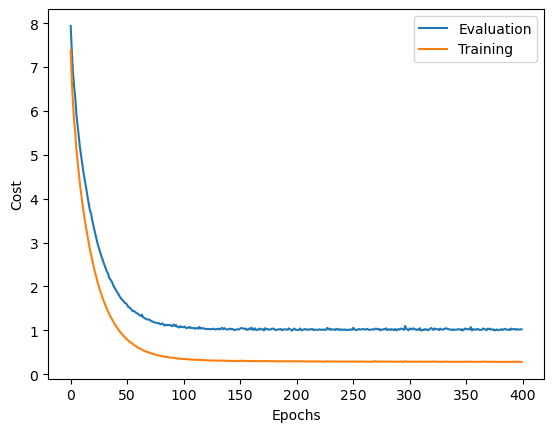

In [54]:
plt.plot([x for x in range(len(res[1]))],res[0],label="Evaluation")
plt.plot([x for x in range(len(res[1]))],res[2],label="Training")


plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Cost")